## Spot Analysis of BF Correction

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_52/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/eups 	setup
lsst_distrib          g7ae64ea4b3+cca76d10ca 	w_latest w_2021_52 current setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit

slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

In [3]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"
butler = Butler(repo_path)
registry = butler.registry

# Pick a sensor
# Interesting sensors: R10_S11, R02_S00
sensor = "R02_S00"

#### Read in BFKs

In [4]:
bfkdir = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/abrought/BF/run_13144/bfks2/20220214T195126Z/bfk/"
bfkfile = glob.glob(bfkdir + "*" + sensor + "*.fits")[0]

hdu_bfk = fits.open(bfkfile)
hdu_bfk[1].columns

ColDefs(
    name = 'AMPLIFIER'; format = '3A'
    name = 'MEANS'; format = '338D'; dim = '(338)'
    name = 'VARIANCES'; format = '338D'; dim = '(338)'
    name = 'RAW_XCORRS'; format = '21632D'; dim = '(21632)'
    name = 'GAIN'; format = 'D'
    name = 'NOISE'; format = 'D'
    name = 'MEAN_XCORRS'; format = '289D'; dim = '(289)'
    name = 'KERNEL'; format = '289D'; dim = '(289)'
    name = 'VALID'; format = 'K'
)

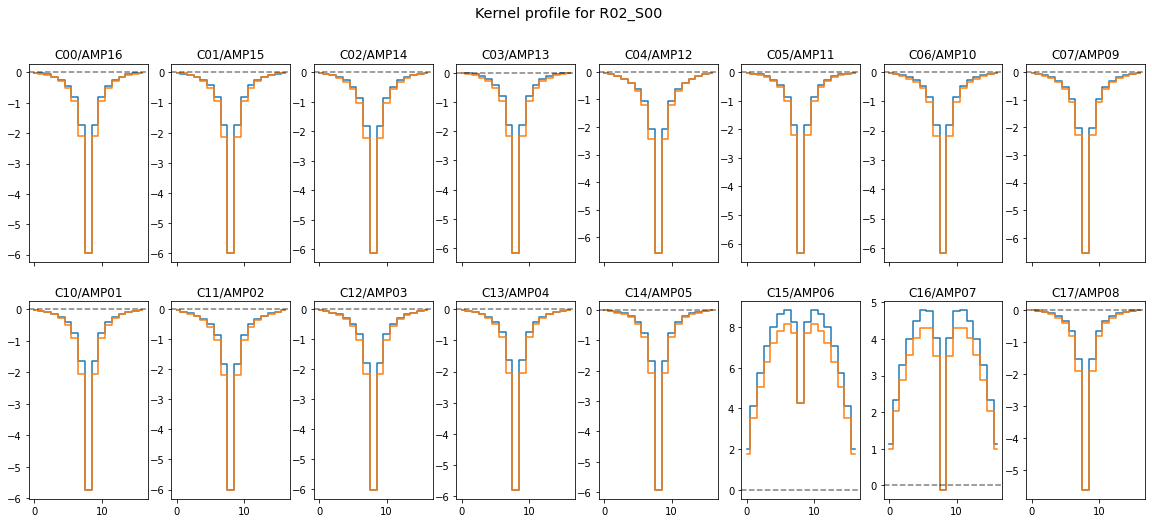

In [5]:
bfks = []
bfks_afterlinearitycorr = []
meanxcorrs = []
meanxcorrs_afterlinearitycorr = []

for i, amp in enumerate(hdu_bfk[1].data):
    bfks.append(amp['KERNEL'].reshape(17,17)*1.0e7)
    meanxcorrs.append(amp['MEAN_XCORRS'].reshape(17,17))


fig, axs = plt.subplots(2,8, sharex=True, sharey=False, squeeze=True, figsize=(20,8), facecolor='w')
plt.suptitle("Kernel profile for " + sensor, fontsize="x-large")
for i in range(16):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    im = ax.plot(bfks[i][:,8], drawstyle='steps-mid')
    im2 = ax.plot(bfks[i][8,:], drawstyle='steps-mid')
    ax.axhline(0.0,linestyle="--", color="black", alpha=0.5)
    ax.set(title=hdu_bfk[1].data[i]['AMPLIFIER'] + "/" + slacAmps[hdu_bfk[1].data[i]['AMPLIFIER']])


##### Linearity residuals

In [6]:
bfk_linearized_dir = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/abrought/BF/run_13144/bfks_linearized/20220307T183913Z/bfk/"
bfk_linearized_file = glob.glob(bfk_linearized_dir + "*" + sensor + "*.fits")[0]

hdu_bfk_linearized = fits.open(bfk_linearized_file)
hdu_bfk_linearized[1].columns

ColDefs(
    name = 'AMPLIFIER'; format = '3A'
    name = 'MEANS'; format = '338D'; dim = '(338)'
    name = 'VARIANCES'; format = '338D'; dim = '(338)'
    name = 'RAW_XCORRS'; format = '21632D'; dim = '(21632)'
    name = 'GAIN'; format = 'D'
    name = 'NOISE'; format = 'D'
    name = 'MEAN_XCORRS'; format = '289D'; dim = '(289)'
    name = 'KERNEL'; format = '289D'; dim = '(289)'
    name = 'VALID'; format = 'K'
)

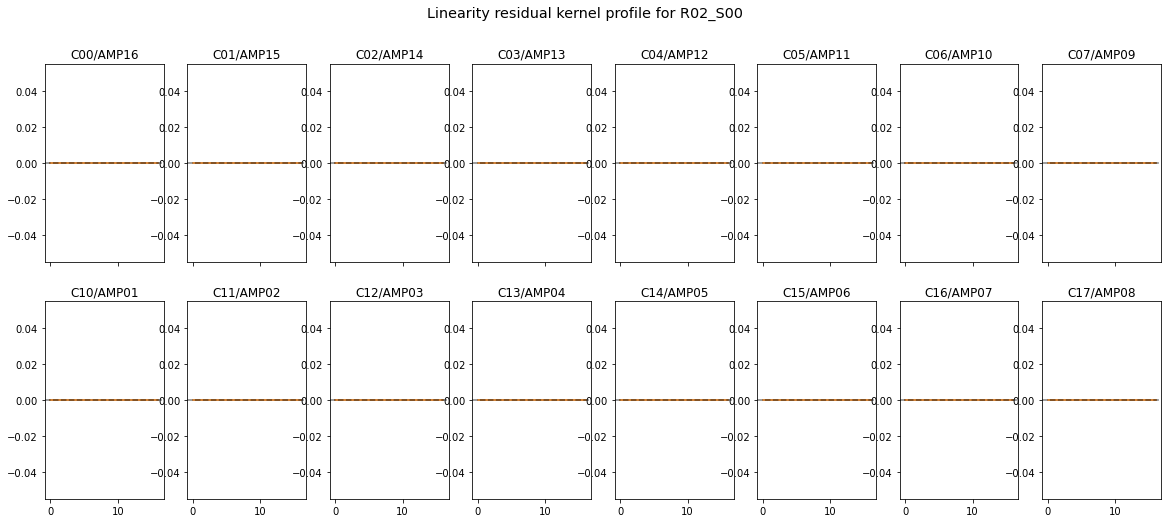

In [7]:
bfks_linearized = []
meanxcorrs_linearized = []

for i, amp in enumerate(hdu_bfk[1].data):
    bfks_linearized.append(amp['KERNEL'].reshape(17,17)*1.0e7)
    meanxcorrs_linearized.append(amp['MEAN_XCORRS'].reshape(17,17))


fig, axs = plt.subplots(2,8, sharex=True, sharey=False, squeeze=True, figsize=(20,8), facecolor='w')
plt.suptitle("Linearity residual kernel profile for " + sensor, fontsize="x-large")
for i in range(16):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    im = ax.plot(bfks_linearized[i][:,8] - bfks[i][:,8], drawstyle='steps-mid')
    im2 = ax.plot(bfks_linearized[i][8,:] - bfks[i][8,:], drawstyle='steps-mid')
    ax.axhline(0.0,linestyle="--", color="black", alpha=0.5)
    ax.set(title=hdu_bfk_linearized[1].data[i]['AMPLIFIER'] + "/" + slacAmps[hdu_bfk_linearized[1].data[i]['AMPLIFIER']])


#### Read in PTCs

In [8]:
ptcdir = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/abrought/BF/run_13144/ptcs/20220207T220227Z/ptc/"
ptcfile = glob.glob(ptcdir + "*" + sensor + "*.fits")[0]

hdu_ptc = fits.open(ptcfile)
hdu_ptc[1].columns

ColDefs(
    name = 'AMPLIFIER_NAME'; format = '3A'
    name = 'PTC_FIT_TYPE'; format = '16A'
    name = 'COV_MATRIX_SIDE'; format = 'K'
    name = 'INPUT_EXP_ID_PAIRS'; format = '676K'; dim = '(2,1,338)'
    name = 'EXP_ID_MASK'; format = '338L'; dim = '(338)'
    name = 'RAW_EXP_TIMES'; format = '338D'; dim = '(338)'
    name = 'RAW_MEANS'; format = '338D'; dim = '(338)'
    name = 'RAW_VARS'; format = '338D'; dim = '(338)'
    name = 'GAIN'; format = 'D'
    name = 'GAIN_ERR'; format = 'D'
    name = 'NOISE'; format = 'D'
    name = 'NOISE_ERR'; format = 'D'
    name = 'PTC_FIT_PARS'; format = '3D'; dim = '(3)'
    name = 'PTC_FIT_PARS_ERROR'; format = '3D'; dim = '(3)'
    name = 'PTC_FIT_CHI_SQ'; format = 'D'
    name = 'COVARIANCES'; format = '21632D'; dim = '(21632)'
    name = 'COVARIANCES_MODEL'; format = '21632D'; dim = '(21632)'
    name = 'COVARIANCES_SQRT_WEIGHTS'; format = '21632D'; dim = '(21632)'
    name = 'A_MATRIX'; format = '64D'; dim = '(64)'
    name = 'B_MATRIX';

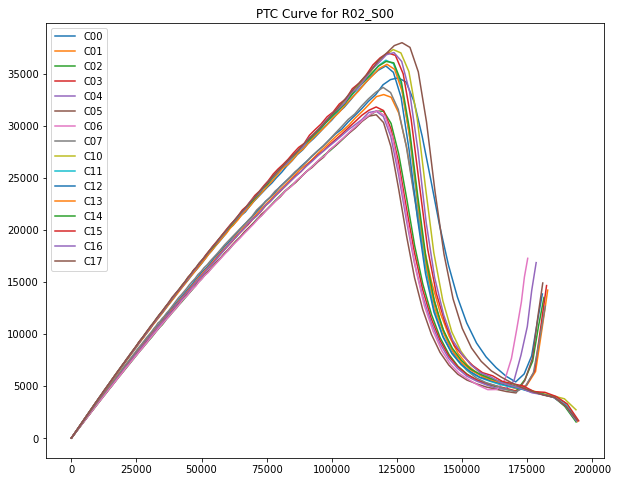

In [9]:
plt.figure(figsize=(10,8))
plt.title("PTC Curve for " + sensor)
for row in hdu_ptc[1].data:
    #if row["AMPLIFIER_NAME"] == "C15" or row["AMPLIFIER_NAME"] == "C16":
        plt.plot(row["RAW_MEANS"]*row["GAIN"], row["RAW_VARS"], label=row["AMPLIFIER_NAME"])
    
    
plt.legend(loc=2)

##### Linearity residuals

In [11]:
ptc_linearized_dir = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/abrought/BF/run_13144/ptcs_linearized/20220307T162935Z/ptc/"
ptc_linearized_file = glob.glob(ptc_linearized_dir + "*" + sensor + "*.fits")[0]

hdu_ptc_linearized = fits.open(ptc_linearized_file)
hdu_ptc_linearized[1].columns

ColDefs(
    name = 'AMPLIFIER_NAME'; format = '3A'
    name = 'PTC_FIT_TYPE'; format = '16A'
    name = 'COV_MATRIX_SIDE'; format = 'K'
    name = 'INPUT_EXP_ID_PAIRS'; format = '676K'; dim = '(2,1,338)'
    name = 'EXP_ID_MASK'; format = '338L'; dim = '(338)'
    name = 'RAW_EXP_TIMES'; format = '338D'; dim = '(338)'
    name = 'RAW_MEANS'; format = '338D'; dim = '(338)'
    name = 'RAW_VARS'; format = '338D'; dim = '(338)'
    name = 'GAIN'; format = 'D'
    name = 'GAIN_ERR'; format = 'D'
    name = 'NOISE'; format = 'D'
    name = 'NOISE_ERR'; format = 'D'
    name = 'PTC_FIT_PARS'; format = '3D'; dim = '(3)'
    name = 'PTC_FIT_PARS_ERROR'; format = '3D'; dim = '(3)'
    name = 'PTC_FIT_CHI_SQ'; format = 'D'
    name = 'COVARIANCES'; format = '21632D'; dim = '(21632)'
    name = 'COVARIANCES_MODEL'; format = '21632D'; dim = '(21632)'
    name = 'COVARIANCES_SQRT_WEIGHTS'; format = '21632D'; dim = '(21632)'
    name = 'A_MATRIX'; format = '64D'; dim = '(64)'
    name = 'B_MATRIX';

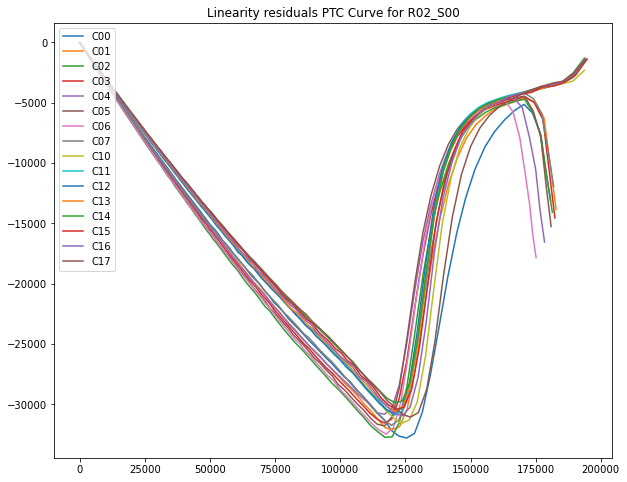

In [12]:
plt.figure(figsize=(10,8))
plt.title("Linearity residuals PTC Curve for " + sensor)
for i,(row,row_linearized) in enumerate(zip(hdu_ptc[1].data, hdu_ptc_linearized[1].data)):
    #if row["AMPLIFIER_NAME"] == "C15" or row["AMPLIFIER_NAME"] == "C16":
        plt.plot(row["RAW_MEANS"]*row["GAIN"], row["RAW_VARS"] - row_linearized["RAW_VARS"], label=row["AMPLIFIER_NAME"])
    
    
plt.legend(loc=2)

In [22]:
lindir = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/abrought/BF/run_13144/linearities/20220228T191504Z/linearizer/"
linfile = glob.glob(lindir + "*" + sensor + "*.fits")[0]

hdu_linearizer = fits.open(linfile)
hdu_linearizer[1].columns

ColDefs(
    name = 'AMPLIFIER_NAME'; format = '3A'
    name = 'TYPE'; format = '4A'
    name = 'COEFFS'; format = '20D'; dim = '(20)'
    name = 'BBOX_X0'; format = 'K'
    name = 'BBOX_Y0'; format = 'K'
    name = 'BBOX_DX'; format = 'K'
    name = 'BBOX_DY'; format = 'K'
    name = 'FIT_PARAMS'; format = 'D'; dim = '(1)'
    name = 'FIT_PARAMS_ERR'; format = 'D'; dim = '(1)'
    name = 'RED_CHI_SQ'; format = 'D'
    name = 'FIT_RES'; format = '338D'; dim = '(338)'
    name = 'LIN_FIT'; format = '2D'; dim = '(2)'
)

In [24]:
Table(hdu_linearizer[1].data)

AMPLIFIER_NAME,TYPE,COEFFS [20],BBOX_X0,BBOX_Y0,BBOX_DX,BBOX_DY,FIT_PARAMS [1],FIT_PARAMS_ERR [1],RED_CHI_SQ,FIT_RES [338],LIN_FIT [2]
str3,str4,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64
C10,None,0.0 .. 0.0,0,2000,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
C11,None,0.0 .. 0.0,509,2000,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
C12,None,0.0 .. 0.0,1018,2000,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
C13,None,0.0 .. 0.0,1527,2000,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
C14,None,0.0 .. 0.0,2036,2000,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
...,...,...,...,...,...,...,...,...,...,...,...
C05,None,0.0 .. 0.0,2545,0,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
C04,None,0.0 .. 0.0,2036,0,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
C03,None,0.0 .. 0.0,1527,0,509,2000,0.0,0.0,nan,0.0 .. 0.0,0.0 .. 0.0
